In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

import torch.utils.data as data
import torch.optim as optim

import numpy as np

In [3]:
def scaled_dot_attention(q, k, v, mask = None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask==0, -9e-15)
    attention = F.softmax(attn_logits, dim = -1)
    values = torch.matmul(attention, v) # (seq_len, seq_len) * (seq_len, d_v) = (seq_len * d_v)
    return values, attention

In [4]:
seq_len, d_k , d_v = 3,2, 5
torch.manual_seed(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_v)

values, attention = scaled_dot_attention(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898, -0.9890,  0.9580,  1.3221],
        [ 0.8172, -0.7658, -0.7506,  1.3525,  0.6863],
        [-0.3278,  0.7950,  0.2815,  0.0562,  0.5227]])
Values
 tensor([[ 0.5820, -0.6564, -0.5281,  0.7936,  0.8920],
        [ 0.5324, -0.5631, -0.4847,  0.7731,  0.8557],
        [ 0.3897, -0.2515, -0.3619,  0.7739,  0.7027]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


In [5]:
q @ k.T

tensor([[ 0.6613,  0.1899,  0.2844],
        [ 0.3708,  0.1698,  0.3118],
        [-2.3606, -0.5682, -0.7514]])

In [6]:
q, k.T

(tensor([[ 0.3367,  0.1288],
         [ 0.2345,  0.2303],
         [-1.1229, -0.1863]]),
 tensor([[ 2.2082,  0.4617,  0.5349],
         [-0.6380,  0.2674,  0.8094]]))

In [7]:
# [0,0] = 0.6613
print(0.3367 *  2.2082 + 0.1288 * -0.6380)

# [1, 2] = 0.3118
print(0.2345 * 0.5349 + 0.2303 * 0.8094)

0.66132654
0.31183887


In [8]:
q @ k.T / math.sqrt(d_k)

tensor([[ 0.4676,  0.1343,  0.2011],
        [ 0.2622,  0.1201,  0.2205],
        [-1.6692, -0.4018, -0.5313]])

In [9]:
F.softmax(q @ k.T / math.sqrt(d_k), dim = -1)

tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])

In [10]:
# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length X seg_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [23]:
class MHA(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Can be combined 
        self.q_proj = nn.Linear(input_dim, embed_dim)
        self.k_proj = nn.Linear(input_dim, embed_dim)
        self.v_proj = nn.Linear(input_dim, embed_dim)

        # Last layer
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        for layer in [self.q_proj, self.k_proj, self.v_proj, self.o_proj]:
            nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0)

    def forward(self, x, mask = None, return_attention = False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        
        # Separate Q, K, V from linear output
        q = q.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
        k = k.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
        v = v.reshape(batch_size, seq_length, self.num_heads, self.head_dim)

        # [Batch, Head, SeqLen, Dims]
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        # Determine value outputs
        values, attention = scaled_dot_attention(q, k, v, mask = mask)
        values = values.permute(0, 2, 1, 3) # [Batch, Seqlen, Heads, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)

        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o         

In [24]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_attention(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [25]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MHA(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

In [26]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Position Encoding

In [27]:
max_len = 10
d_model = 4
pe = torch.zeros(max_len, d_model)
position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/ d_model))
position

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [28]:
div_term

tensor([1.0000, 0.0100])

In [29]:
pe

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [30]:
pe[:, 0::2] = torch.sin(position * div_term)
print(pe)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0000,  0.0100,  0.0000],
        [ 0.9093,  0.0000,  0.0200,  0.0000],
        [ 0.1411,  0.0000,  0.0300,  0.0000],
        [-0.7568,  0.0000,  0.0400,  0.0000],
        [-0.9589,  0.0000,  0.0500,  0.0000],
        [-0.2794,  0.0000,  0.0600,  0.0000],
        [ 0.6570,  0.0000,  0.0699,  0.0000],
        [ 0.9894,  0.0000,  0.0799,  0.0000],
        [ 0.4121,  0.0000,  0.0899,  0.0000]])


In [31]:
pe[:, 1::2] = torch.cos(position * div_term)
print(pe)

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  1.0000],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996],
        [-0.7568, -0.6536,  0.0400,  0.9992],
        [-0.9589,  0.2837,  0.0500,  0.9988],
        [-0.2794,  0.9602,  0.0600,  0.9982],
        [ 0.6570,  0.7539,  0.0699,  0.9976],
        [ 0.9894, -0.1455,  0.0799,  0.9968],
        [ 0.4121, -0.9111,  0.0899,  0.9960]])


In [32]:
pe = pe.unsqueeze(0)
pe.shape

torch.Size([1, 10, 4])

In [33]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len = 5000):

        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representig the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/ d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe, persistent = False)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]

        return x

In [34]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch = self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 /self.warmup
        return lr_factor

In [153]:
class TransformerPredictor(nn.Module):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout = 0.0, input_dropout = 0.0):
        super().__init__()
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.lr = lr
        self.warmup = warmup
        self.max_iters = max_iters
        self.dropout = dropout
        self.input_dropout = input_dropout
        
        self._create_model()

    def _create_model(self):

        # Input dim -> Model Dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.input_dropout),
            nn.Linear(self.input_dim, self.model_dim)
        )

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(d_model = self.model_dim)

        # Transformer
        self.transformer = TransformerEncoder(
            num_layers = self.num_layers,
            input_dim = self.model_dim,
            dim_feedforward = 2 * self.model_dim,
            num_heads = self.num_heads,
            dropout = self.dropout
        )

        self.output_net = nn.Sequential(
            nn.Flatten(), # (Batch, seq_len, model_dim) => (Batch , seq_len * model_dim)
            nn.Linear(seq_len * self.model_dim, seq_len * self.model_dim),
            nn.LayerNorm(seq_len * self.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(seq_len * self.model_dim, 3 * self.num_classes), # (Batch , seq_len * model_dim) => (Batch, 3 * num_classes)
            nn.Unflatten(1, (3, self.num_classes))
        )

    def forward(self, x, mask = None, add_positional_encoding = True):

        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        
        x = self.transformer(x, mask = mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask = None, add_positional_encoding=True):
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask = mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = self.lr)

        lr_scheduler = CosineWarmupScheduler(
            optimizer, 
            warmup = self.warmup,
            max_iters=self.max_iters)
        return optimizer, lr_scheduler        

In [154]:
# Test experiment
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size = (self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data[-3:], dims=(0,))
        return inp_data, labels

In [155]:
from functools import partial
num_categories = 10
seq_len = 16

dataset = partial(ReverseDataset, num_categories, seq_len) # Partially filled num_categories, seq_len
train_loader = data.DataLoader(dataset(50000), batch_size = 128, shuffle = True, drop_last = True, pin_memory = True)
val_loader = data.DataLoader(dataset(1000), batch_size = 128)
test_loader = data.DataLoader(dataset(10000), batch_size = 128)

In [156]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([4, 0, 1, 9, 0, 2, 4, 5, 5, 7, 7, 1, 0, 3, 9, 4])
Labels:     tensor([4, 9, 3])


In [195]:
epochs = 51

input_dim = num_categories
model_dim = 36
num_classes = num_categories
num_heads = 4
num_layers = 3
lr = 5e-4
warmup = 50
max_iters = 100

In [196]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [197]:
criterion = nn.CrossEntropyLoss()

model = TransformerPredictor(input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters)
optimizer, scheduler = model.configure_optimizers() 

for epoch in range(epochs):

    # Train phase
    model.train()
    running_training_loss = 0
    for train_data in train_loader:
        # Reset grad
        optimizer.zero_grad()
        
        x, y = train_data
        # Need to convert to OHE with num_classes dimension
        y = F.one_hot(y, num_classes = num_classes).float()
        x = F.one_hot(x, num_classes = num_classes).float()

        outputs = model(x)
        loss = criterion(outputs, y)
        running_training_loss += loss.item()
        # Calculate gradient adjustments
        loss.backward()
        # Update gradient based on calculated gradient adjustments
        optimizer.step()

    scheduled_lr = scheduler.get_lr()[0]
    # Update optimizer lr
    scheduler.step()
        
    # Validation phase
    model.eval()
    with torch.no_grad():
        running_valid_loss = 0.0
        for valid_data in val_loader:
            valid_x, valid_y = valid_data
            # Need to convert to OHE with num_classes dimension
            valid_y = F.one_hot(valid_y, num_classes = num_classes).float()
            valid_x = F.one_hot(valid_x, num_classes = num_classes).float()
    
            outputs_valid = model(valid_x)
            valid_loss = criterion(outputs_valid, valid_y)
            running_valid_loss += valid_loss
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1} / {epochs}')
        print(f'Learning Rate = {scheduled_lr:.10E}')
        print(f'Training loss = {running_training_loss:.4f}')    
        print(f'Validation Loss = {running_valid_loss:.4f}')

print('-'*20)
print('Completed Training')

Epoch 1 / 51
Learning Rate = 0.0000000000E+00
Training loss = 135.9000
Validation Loss = 2.8007
Epoch 11 / 51
Learning Rate = 9.7552825815E-05
Training loss = 16.4517
Validation Loss = 0.3390
Epoch 21 / 51
Learning Rate = 1.8090169944E-04
Training loss = 16.2862
Validation Loss = 0.3351
Epoch 31 / 51
Learning Rate = 2.3816778784E-04
Training loss = 16.2068
Validation Loss = 0.3346
Epoch 41 / 51
Learning Rate = 2.6180339887E-04
Training loss = 16.1609
Validation Loss = 0.3337
Epoch 51 / 51
Learning Rate = 2.5000000000E-04
Training loss = 16.1470
Validation Loss = 0.3330
--------------------
Completed Training


In [198]:
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=num_classes).float()
inp_data = inp_data.to(device)
attention_maps = model.get_attention_maps(inp_data)

In [199]:
data_input

tensor([[2, 4, 3,  ..., 3, 2, 0],
        [8, 5, 8,  ..., 4, 5, 5],
        [0, 3, 9,  ..., 8, 9, 2],
        ...,
        [9, 3, 2,  ..., 1, 0, 2],
        [1, 9, 5,  ..., 6, 3, 8],
        [9, 1, 2,  ..., 0, 7, 2]])

In [200]:
labels[:5]

tensor([[0, 2, 3],
        [5, 5, 4],
        [2, 9, 8],
        [8, 3, 3],
        [4, 0, 1]])

tensor([1, 4, 5, 4, 1, 3, 8, 1, 2, 2, 2, 5, 6, 0, 2, 5])
tensor([5, 2, 0])


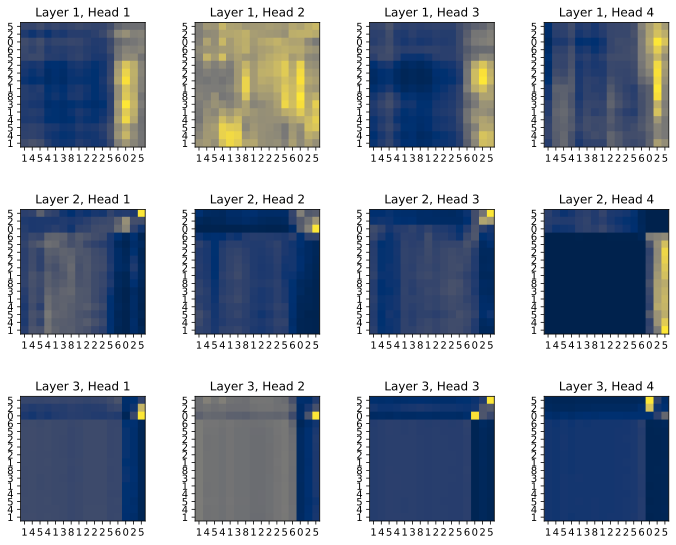

In [204]:
idx = 98
print(data_input[idx])
print(labels[idx])

plot_attention_maps(data_input, attention_maps, idx=idx)

In [44]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
# %matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
# import seaborn as sns

def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

/var/folders/r7/ycczx7s129191ftx0h0ww3mh0000gp/T/ipykernel_87088/2022139006.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

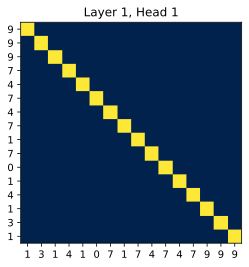

In [253]:
plot_attention_maps(data_input, attention_maps, idx=0)

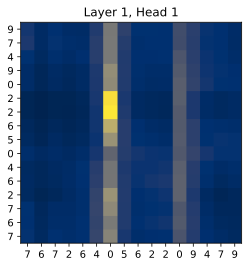

In [227]:
plot_attention_maps(data_input, attention_maps, idx=0)